In [1]:
# Clone the repository and install the necessary packages
!git clone https://github.com/JakubMartinka/karlsruhe2024.git
!pip3 install mlatom
!pip3 install pyscf
!pip3 install mkl
!pip3 install mkl-service

Cloning into 'karlsruhe2024'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 79 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (79/79), 29.85 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (13/13), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 3.9 MB/s eta 0:00:00


In [2]:
import mlatom as ml
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# prepare H2 geometries with bond lengths ranging from 0.5 to 5.0 Å
xyz = np.zeros((451, 2, 3))
xyz[:, 1, 2] = np.arange(0.5, 5.01, 0.01)
z = np.ones((451, 2)).astype(int)
molDB = ml.molecular_database.from_numpy(coordinates=xyz, species=z)

In [6]:
# calculate HF energies
hf = ml.models.methods(method='HF/STO-3G', program='PySCF')
hf.predict(molecular_database=molDB, calculate_energy=True, calculate_energy_gradients=True)

In [7]:
Ntrain = 100
trainDB, testDB = molDB.split(sampling='random', number_of_splits=2, fraction_of_points_in_splits=[Ntrain/451, 1-Ntrain/451])

In [8]:
subtrainDB, valDB = trainDB.split(sampling='random', number_of_splits=2, fraction_of_points_in_splits=[0.9, 0.1])

In [9]:
len(valDB)

10

In [12]:
# setup the KREG model
kreg = ml.models.kreg(model_file='KREG.npz', ml_program='KREG_API')
# optimize its hyperparameters
kreg.hyperparameters['sigma'].minval = 2**-5 # modify the default lower bound of the hyperparameter sigma
kreg.optimize_hyperparameters(subtraining_molecular_database=subtrainDB,
                              validation_molecular_database=valDB,
                              optimization_algorithm='grid',
                              hyperparameters=['lambda', 'sigma'],
                              training_kwargs={'property_to_learn': 'energy'},
                              prediction_kwargs={'property_to_predict': 'estimated_energy'})
lmbd = kreg.hyperparameters['lambda'].value ; sigma=kreg.hyperparameters['sigma'].value
valloss = kreg.validation_loss
print('Optimized sigma:', sigma)
print('Optimized lambda:', lmbd)
print('Optimized validation loss:', valloss)
# Train the model with the optimized hyperparameters to dump it to disk.
kreg.train(molecular_database=subtrainDB, property_to_learn='energy')

Optimized sigma: 0.35355339059327373
Optimized lambda: 2.5999730412131705e-07
Optimized validation loss: 0.0008697508703617364


In [13]:
# predict with the energy-only KREG model
kreg.predict(molecular_database=molDB, property_to_predict='estimated_energy', xyz_derivative_property_to_predict='estimated_gradients')

In [14]:
testRMSE_E = ml.stats.rmse(testDB.get_properties('energy'), testDB.get_properties('estimated_energy'))*ml.constants.Hartree2kcalpermol
testRMSE_F = ml.stats.rmse(testDB.get_xyz_vectorial_properties('energy_gradients').flatten(), testDB.get_xyz_vectorial_properties('estimated_gradients').flatten())*ml.constants.Hartree2kcalpermol

In [15]:
print(f'Test RMSE for energies: {testRMSE_E} Hartree')
print(f'Test RMSE for forces: {testRMSE_F} Hartree/Angstrom')

Test RMSE for energies: 0.3406927348143542 Hartree
Test RMSE for forces: 4.64793966202894 Hartree/Angstrom


In [16]:
values = testDB.get_properties('energy')
estimated_values = testDB.get_properties('estimated_energy')

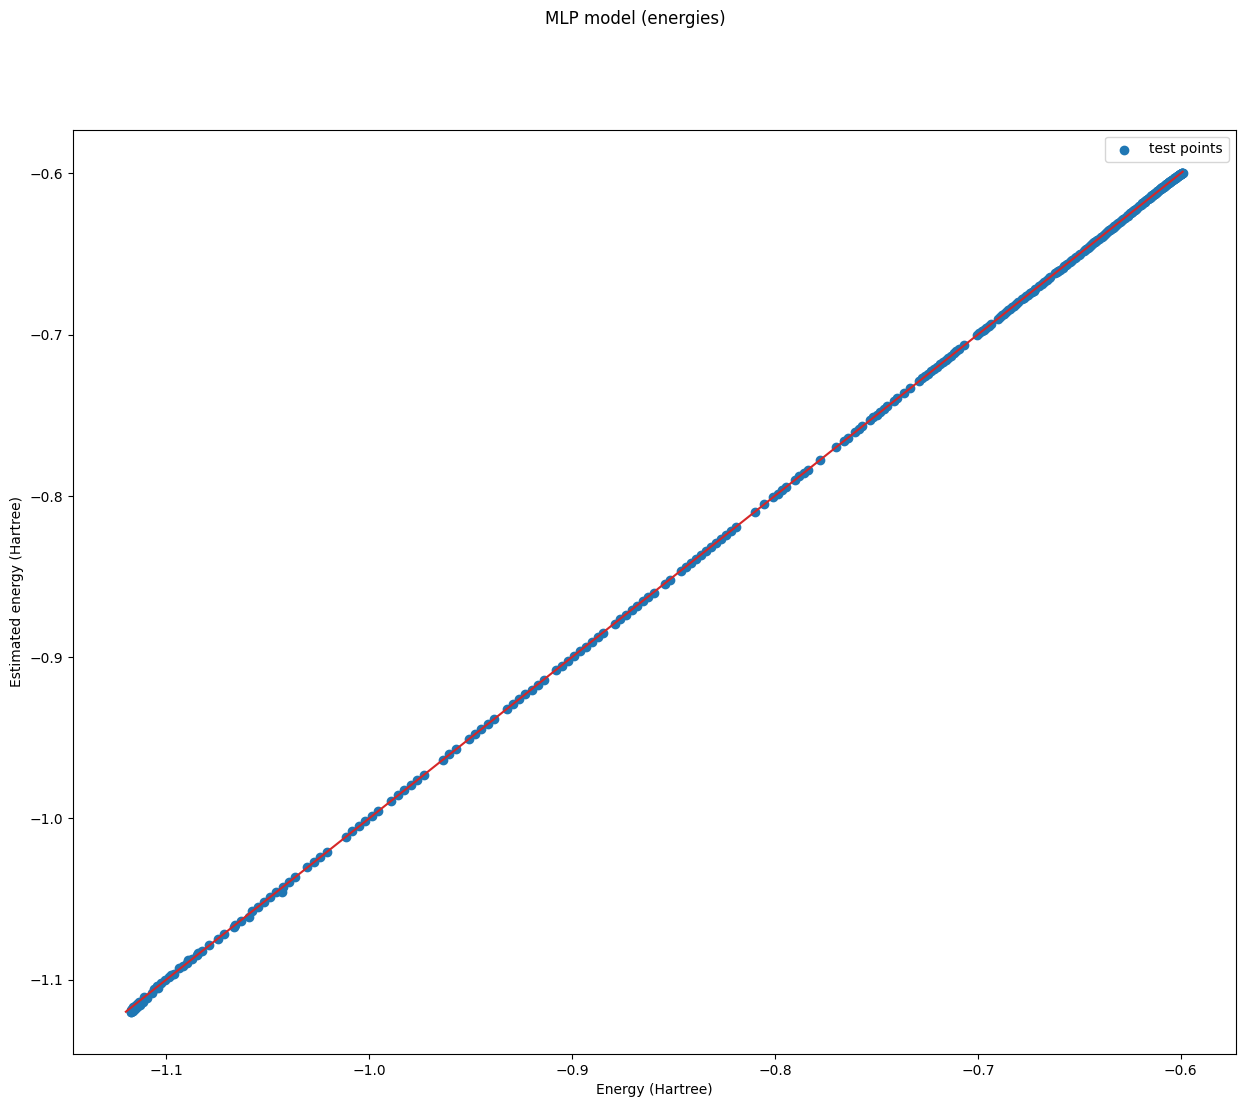

In [17]:
fig,ax = plt.subplots()
fig.set_size_inches(15,12)
diagonal_line = [min([min(values),min(estimated_values)]),max([max(values),max(estimated_values)])]
ax.plot(diagonal_line,diagonal_line,color='C3')
#ax.scatter(values[0:Nsubtrain],estimated_values[0:Nsubtrain],color='C0',label='subtraining points')
#ax.scatter(values[Nsubtrain:Ntrain],estimated_values[Nsubtrain:Ntrain],color='C1',label='validation points')
ax.scatter(values,estimated_values,color='C0',label='test points')
ax.set_xlabel(f'Energy (Hartree)')
ax.set_ylabel(f'Estimated energy (Hartree)')
plt.suptitle(f'MLP model (energies)')
plt.legend()

# Train with forces

In [18]:
# setup the KREG model
kreg_engrad = ml.models.kreg(model_file='KREG_engrad.npz', ml_program='KREG_API')
# optimize its hyperparameters
kreg_engrad.hyperparameters['sigma'].minval = 2**-5 # modify the default lower bound of the hyperparameter sigma
kreg_engrad.optimize_hyperparameters(subtraining_molecular_database=subtrainDB,
                              validation_molecular_database=valDB,
                              optimization_algorithm='grid',
                              hyperparameters=['lambda', 'sigma'],
                              training_kwargs={'property_to_learn': 'energy', 'xyz_derivative_property_to_learn': 'energy_gradients'},
                              prediction_kwargs={'property_to_predict': 'estimated_energy',
                                                 'xyz_derivative_property_to_predict': 'estimated_gradients'})
lmbd = kreg_engrad.hyperparameters['lambda'].value ; sigma=kreg_engrad.hyperparameters['sigma'].value
valloss = kreg_engrad.validation_loss
print('Optimized sigma:', sigma)
print('Optimized lambda:', lmbd)
print('Optimized validation loss:', valloss)
# Train the model with the optimized hyperparameters to dump it to disk.
kreg_engrad.train(molecular_database=subtrainDB, property_to_learn='energy', xyz_derivative_property_to_learn='energy_gradients')

Optimized sigma: 0.35355339059327373
Optimized lambda: 2.5999730412131705e-07
Optimized validation loss: 0.0017082689383844008


In [19]:
# predict with the energy & gradients KREG model
kreg_engrad.predict(molecular_database=molDB, property_to_predict='estimated_energy', xyz_derivative_property_to_predict='estimated_gradients')

In [20]:
testRMSE_E = ml.stats.rmse(testDB.get_properties('energy'), testDB.get_properties('estimated_energy'))*ml.constants.Hartree2kcalpermol
testRMSE_F = ml.stats.rmse(testDB.get_xyz_vectorial_properties('energy_gradients').flatten(), testDB.get_xyz_vectorial_properties('estimated_gradients').flatten())*ml.constants.Hartree2kcalpermol
print(f'Test RMSE for energies: {testRMSE_E} Hartree')
print(f'Test RMSE for forces: {testRMSE_F} Hartree/Angstrom')

Test RMSE for energies: 0.10796307647553155 Hartree
Test RMSE for forces: 3.946119394637283 Hartree/Angstrom


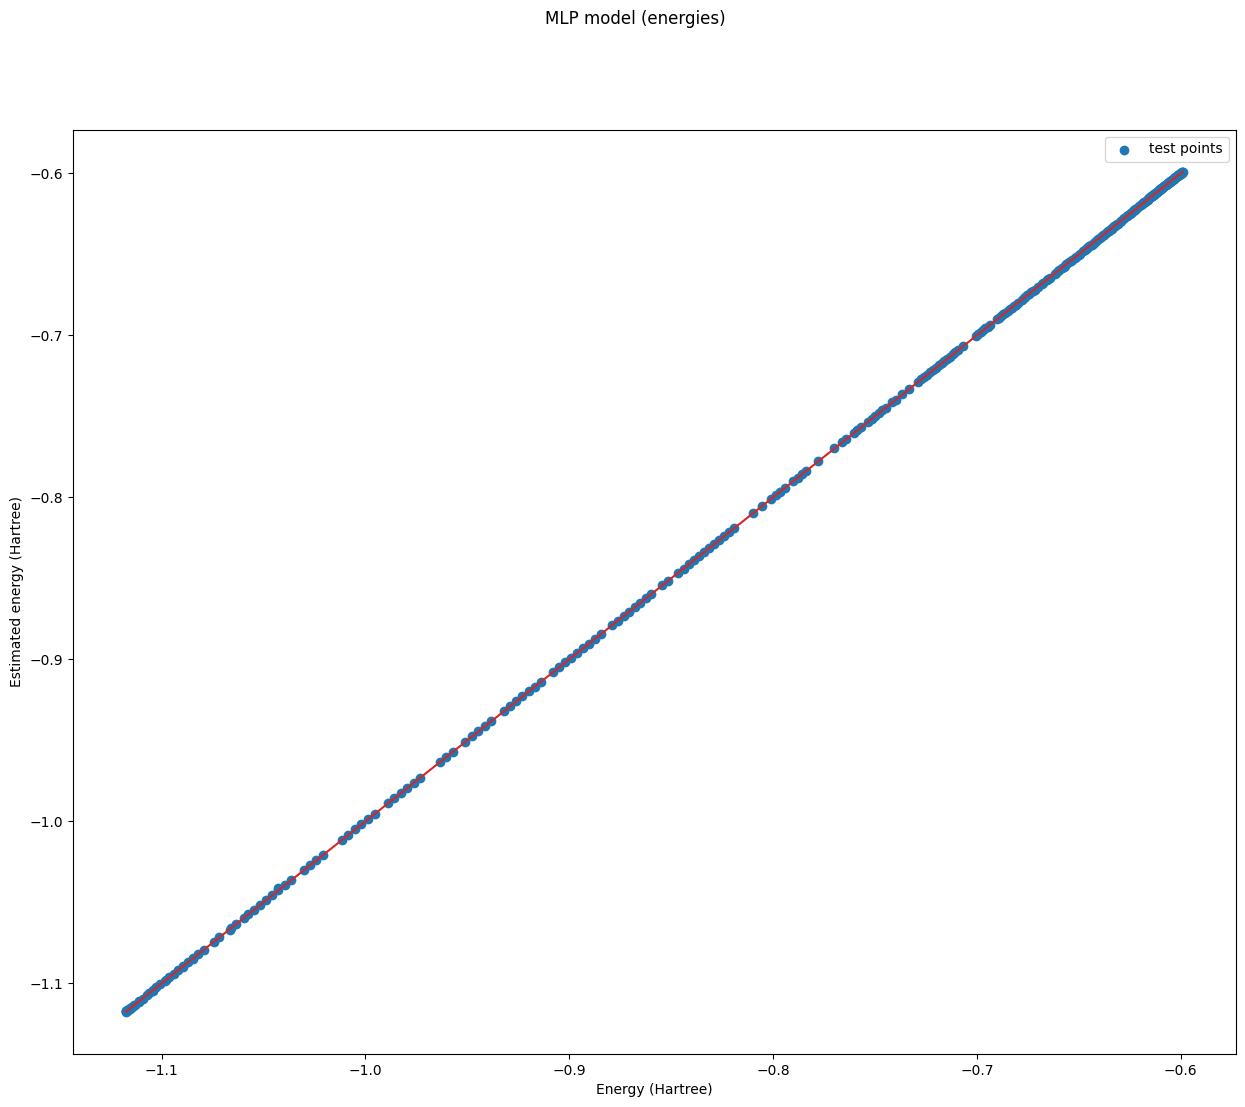

In [21]:
values = testDB.get_properties('energy')
estimated_values = testDB.get_properties('estimated_energy')
fig,ax = plt.subplots()
fig.set_size_inches(15,12)
diagonal_line = [min([min(values),min(estimated_values)]),max([max(values),max(estimated_values)])]
ax.plot(diagonal_line,diagonal_line,color='C3')
#ax.scatter(values[0:Nsubtrain],estimated_values[0:Nsubtrain],color='C0',label='subtraining points')
#ax.scatter(values[Nsubtrain:Ntrain],estimated_values[Nsubtrain:Ntrain],color='C1',label='validation points')
ax.scatter(values,estimated_values,color='C0',label='test points')
ax.set_xlabel(f'Energy (Hartree)')
ax.set_ylabel(f'Estimated energy (Hartree)')
plt.suptitle(f'MLP model (energies)')
plt.legend()

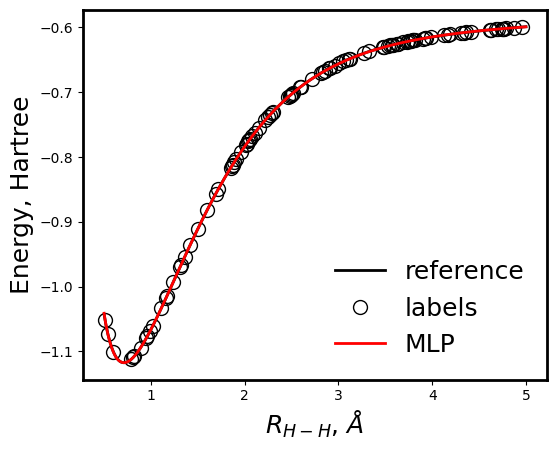

In [22]:
plot = ml.plot.plot()
%matplotlib inline
#plot.savein='h2_pec.png'
plot.plottype='linechart_without_points'
xref = [mol.atoms[1].xyz_coordinates[2] for mol in molDB.molecules]
yref = [mol.energy for mol in molDB.molecules]
plot.xs.append(xref)
plot.ys.append(yref)
plot.labels.append('reference') ; plot.colors.append('k') ; plot.linewidths.append(2) ; plot.markers.append('')
xlabeled = [mol.atoms[1].xyz_coordinates[2] for mol in trainDB.molecules]
ylabeled = [mol.energy for mol in trainDB.molecules]
plot.xs.append(xlabeled)
plot.ys.append(ylabeled)
plot.labels.append('labels') ; plot.colors.append('k') ; plot.linewidths.append(0) ; plot.markers.append('o')
xest = [mol.atoms[1].xyz_coordinates[2] for mol in molDB.molecules]
yest = [mol.estimated_energy for mol in molDB.molecules]
plot.xs.append(xest)
plot.ys.append(yest)
plot.labels.append('MLP') ; plot.colors.append('r') ; plot.linewidths.append(2) ; plot.markers.append('')
plot.xaxis_caption = '$R_{H-H}$, $\AA$'
plot.yaxis_caption = 'Energy, Hartree'
plot.make_figure()